In [32]:
import pandas as pd
import geopandas
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# The Major Arrests Dataset
I decided that my metric would center around safety, and I found this particular data set to be perfect, as it listed the neighborhoods by alphabetical order, and included population and overall crime rate for each.

In [33]:
# import csv data file, drops incidents without neighborhoods
major_arrests = pd.read_csv("major-arrests.csv")
major_arrests.dropna(subset = ["neighborhood"], inplace = True)

# keep overall crime rate (since thats what I chose to look at and assuming this was calculated with based on population size)
crime_rate = major_arrests[['neighborhood','overall_crime_rate']]
                           
# sort in ascending order of crime rate and neighborhood
crime_rate_final = crime_rate.sort_values(by=['overall_crime_rate'], ascending=True)
crime_rate_final.head(5)

,neighborhood,overall_crime_rate
27,Harpen Hilltop,0.99
17,Crafton Heights - Westwood - Oakwood,1.41
41,Morningside,1.61
12,Brighton Heights,1.64
22,Elliot,1.70


## Visuals

Text(0, 0.5, 'Crime Rate')

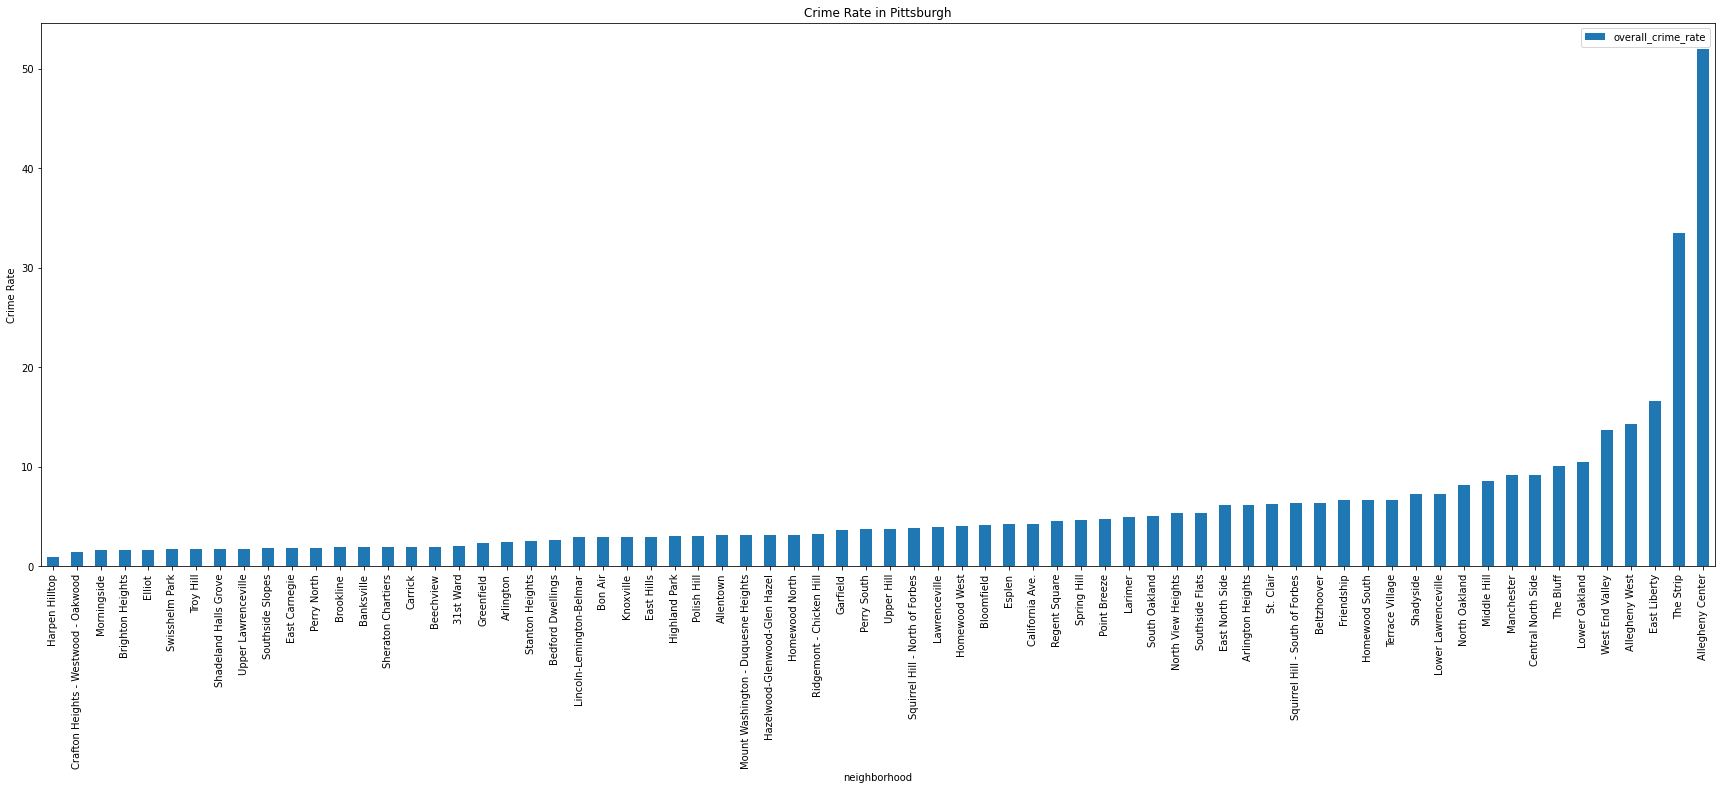

In [34]:
# bar graph
crime_rate_final.plot.bar(x='neighborhood',rot = 90, y='overall_crime_rate',figsize=(30,10))
plt.title("Crime Rate in Pittsburgh")
plt.ylabel("Crime Rate")

Top 5 Best Neighborhoods:
 1. Harpen Hilltop
 2. Crafton Heights-Westwood-Oakwood
 3. Morningside
 4. Brighton Heights
 5. Elliot

In [35]:
# applying a scale for further measurement of the best neighborhood when comparing with other data
# normalizing values on a scale of 0-10
normalized_crime = crime_rate_final
maxVal = normalized_crime.max().iloc[1]
minVal = normalized_crime.min().iloc[1]
maxVal -= minVal

neighborhoodDictionary = {}

for i in range (len(normalized_crime)):
    neighborhoodDictionary[normalized_crime.iloc[i].iloc[0]] = 10 - ((normalized_crime.iloc[i].iloc[1] - minVal) / maxVal) * 10

My personal favorite neighborhood in Pittsburgh is the Strip District because it is so culturally diverse. The data driven determination of the “best neighborhood” came out to be Summer Hill/Harpen Hilltop in my data set, and Squirrel Hill North using the group’s metric of low crime rate, high school enrollment, and abundance of parks. The Strip had one of the highest crime rates among the other neighborhoods, telling me it’s not the safest area to be in considering the crime rate was calculated based on the arrests for major crimes like rape, murder, robbery, and assault. Squirrel Hill North was on the lower side of the crime rate, making it a good pick for best neighborhood.

# The School Enrollment Dataset

For my metric, I used a dataset on the school enrollment of the neighborhoods.

In [36]:
df = pd.read_csv("school_enrollment.csv")

This code subtracts the undergraduate students from the total number of students enrolled in that neighborhood and from the total number of people in that neighborhood. I did this because North and Central Oakland house most of the Pitt students, so it makes the data more fair to eliminate the undergraduate students from the data. Additionally, it creates a ratio of the total number of students divided by the total number of individuals in each neighborhood. This makes the data more fair as some neighborhoods have a lot more people than others.

In [37]:
# Subtracting out Undergraduate students from total enrolled students and total people
df['Total Students Enrolled'] = df['Estimate; Enrolled in school:'] - df['Estimate; Enrolled in school: - Enrolled in college, undergraduate years']
df['Total'] = df['Estimate; Total:'] - df['Estimate; Enrolled in school: - Enrolled in college, undergraduate years']

# Creating a ratio to make values more fair since some neighborhoods have larger populations
df['Ratio'] = df['Total Students Enrolled'] / df['Total']

# Making a new dataset for ratio data
df_ratio = df[['Neighborhood', 'Ratio']]
df_ratio = df_ratio.sort_values('Ratio', ascending=False)
df_ratio.head(10)

,Neighborhood,Ratio
40,Homewood North,0.360072
2,Allentown,0.350731
58,Northview Heights,0.335810
29,Elliott,0.321233
43,Knoxville,0.314637
56,North Oakland,0.310575
70,South Oakland,0.297645
33,Friendship,0.293805
68,Shadyside,0.281091
19,Central Oakland,0.278465


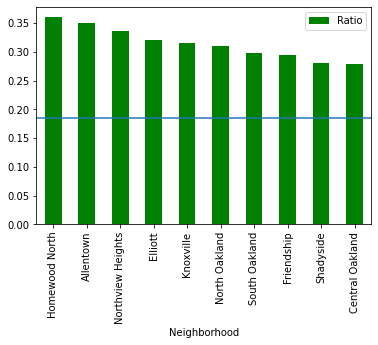

In [38]:
# Finding the mean and plotting my ratio data with the mean
mean = df['Ratio'].mean()
df_ratio[0:10].plot.bar(rot=90, x = 'Neighborhood', color = 'g')
plt.axhline(mean)

In [39]:
# Making my values out of 10 to be able to rank them in order to find the best neighborhood from all our metrics
num = 10 / (df['Ratio'].iloc[40])
df['Final Rank'] = df['Ratio'] * num
df_finalrank = df[['Neighborhood', 'Final Rank']]
df_finalrank = df_finalrank.sort_values('Final Rank', ascending=False)
df_finalrank.head(10)

,Neighborhood,Final Rank
40,Homewood North,10.000000
2,Allentown,9.740573
58,Northview Heights,9.326186
29,Elliott,8.921345
43,Knoxville,8.738164
56,North Oakland,8.625366
70,South Oakland,8.266252
33,Friendship,8.159628
68,Shadyside,7.806511
19,Central Oakland,7.733603


Based off my results, I can conclude that Homewood North is the best neighborhood. Homewood North had the highest ratio of people enrolled in school by the total number of people in the neighborhood. The average ratio of all of the neighborhoods was 0.185, so Homewood North is well above the average. Having a high rate of individuals enrolled in school is an important factor to look at when choosing a neighborhood because it means education is accessible. Additionally, you can infer that the education is of high quality in Homewood North since there are so many people enrolled. Education is obviously very important for both children and adults as it can have several positive affects on us and those around us. Also, the education level of a neighborhood will most likely affect other factors of that neighborhood.

# The Parks Dataset

For this metric we will be using a dataset of parks. This dataset contains a list of pittsburgh parks, along with their acreage and location.

In [40]:

parkDataset = pd.read_csv("Parks.csv")
neighborhoodDataset = pd.read_csv("Neighborhoods.csv")

## The Dataset's Weak Point

Sadly, this dataset does not directly tell us which neighborhoods the parks belong to. It does, however, tell us  
which sector of the city it belongs to. As long as we can find which neighborhoods belong to which sectors, this will let us use  
the parks dataset.

## Neighboring Sectors

A park is not solely used by those in the same sector as it, so we need to find out which sectors neighbor eachother.  
by searching for a map of neighboring sectors in Pittsburgh, you'll come across a link to the official city website.  
The PDF document linked contains this helpful map:

[![sectors.png](https://i.postimg.cc/7hTCC67M/sectors.png)](https://postimg.cc/1VsR2yvf)

The following code is the manual mapping of neighbors for each sector

In [41]:
neighbors = [[None]] * 17
neighbors[1] = [2, 3, 13]
neighbors[2] = [3, 1]
neighbors[3] = [16, 1, 2, 4]
neighbors[4] = [6, 5, 3]
neighbors[5] = [4, 6, 7]
neighbors[6] = [4, 5, 7, 16]
neighbors[7] = [8, 9, 14,15, 5, 6]
neighbors[8] = [7, 9]
neighbors[9] = [10, 14, 7, 8]
neighbors[10] = [11, 12, 14, 9]
neighbors[11] = [10, 12]
neighbors[12] = [10, 11, 13, 14]
neighbors[13] = [1, 12, 15, 16]
neighbors[14] = [15, 7, 8, 10, 12]
neighbors[15] = [13, 14, 7, 16]
neighbors[16] = [15, 13, 7, 6, 4, 3]

## Which neighborhoods go where?

Luckily, the neighborhoods dataset from WPRDC contains the exact same sector mapping as the  
parks dataset. Using this, we will put every neighborhood in its proper sector.

In [42]:
#Create a list of dictionaries for every sector
sectorNeighborhoods = [{}]
for i in range(16):
    sectorNeighborhoods.append({})

In [43]:

# Fill our list of dictionaries with the neighborhood in the corresponding sector
for index, row in neighborhoodDataset.iterrows():
    sectorNeighborhoods[int(row["sectors"])][row["hood"]] = 0


## The Metric

The parks dataset already provides an extremely useful metric: size.  
For every park, we will add its acreage to the neighborhoods in its sector.  
Furthermore, we will use the list of neighbors to give each neighbor slightly lower  
amount of acreage.

In [44]:
# Set a modifier for neighboring sectors
modifier = 4

In [45]:
# Start filling our neighborhoods using our metric
for index, row in parkDataset.iterrows():
    try:
        sector = int(row["sector"])
    except:
        # Error in the dataset, we don't know where this park is!
        None
    for neighborhood in sectorNeighborhoods[sector]:
        sectorNeighborhoods[sector][neighborhood] += row["acreage"]
    for neighbor in neighbors[sector]:
        for neighborhood in sectorNeighborhoods[neighbor]:
            sectorNeighborhoods[neighbor][neighborhood] += row["acreage"] / modifier

In [46]:
allHoods = {}

# Unsectorize the neighborhoods
for i in range(len(sectorNeighborhoods)):
    for neighborhood in sectorNeighborhoods[i]:
        allHoods[neighborhood] = sectorNeighborhoods[i][neighborhood]

## Unpacking the data

Looking at the graph below, it appears Squirrel Hill North/South, Point Breeze, Swisshelm Park, and Regent Square  
blow the other neighborhoods out of the water. This makes sense, as these neighborhoods have a pretty central position  
in the city, as well has having parks such as Schenley 

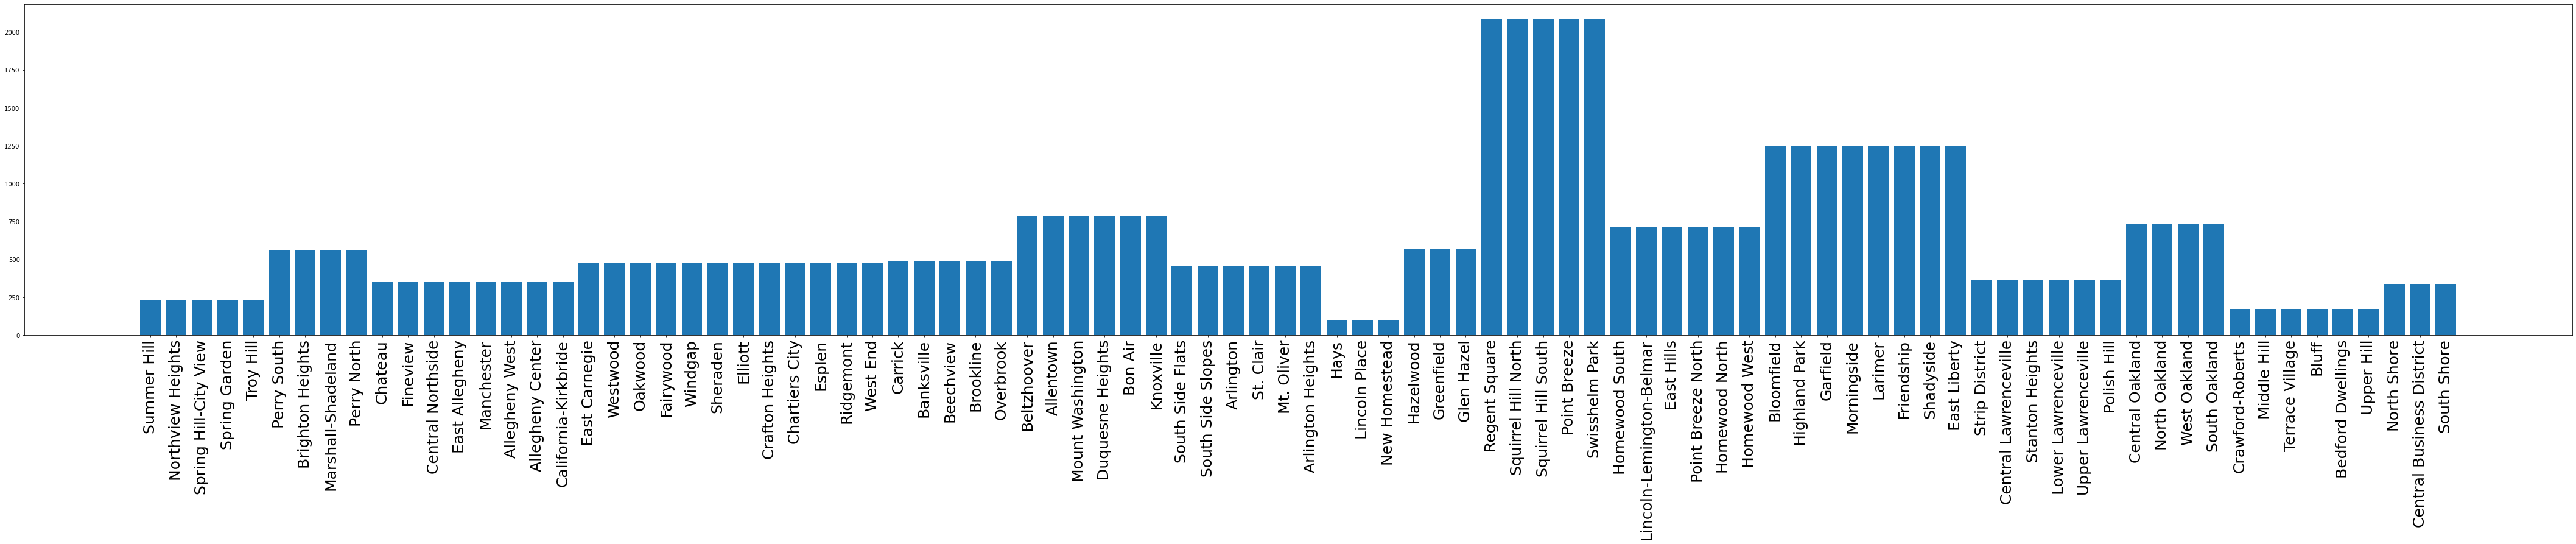

In [47]:
# Graph our Data
plt.figure(figsize = (75,10))
plt.xticks(rotation = 90)
plt.xticks(fontsize= 25)
plt.bar(allHoods.keys(), allHoods.values())
plt.show()

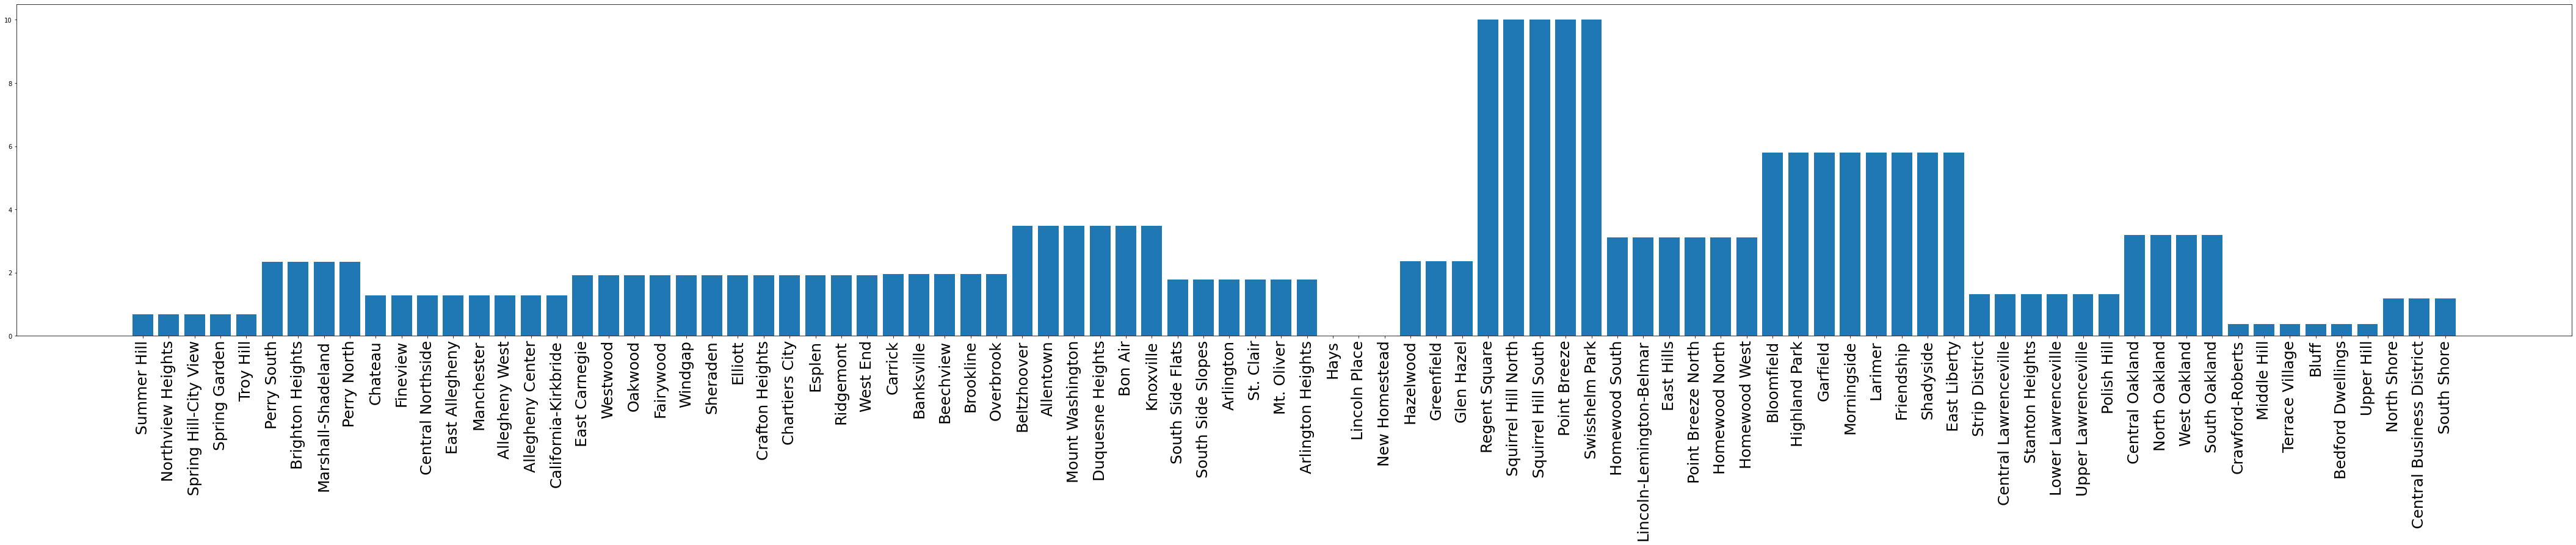

In [48]:
# Normalize values to be between 0 and 10
normalizedValues = allHoods
maxVal = max(allHoods.values())
minVal = min(allHoods.values())
maxVal -= minVal

for neighborhood in normalizedValues:
    normalizedValues[neighborhood] = ((normalizedValues[neighborhood] - minVal) / maxVal) * 10


# Nothing should change here besides the scale
plt.figure(figsize = (75, 10))
plt.xticks(rotation = 90)
plt.xticks(fontsize= 25)
plt.bar(normalizedValues.keys(), normalizedValues.values())
plt.show()
    

Based on my use of the parks dataset, it is no surprise both Squirrel Hills are at the top of the leaderboard. They have a relatively central position in the city, 
and are located near both Frick and Schenley park. This trend carries over to the final results. This data falls in line with what I consider to be 
my favorite neighborhood, as I frequent Squirrel Hill quite often. I believe the final result of my metric is also a clear indicator of not just data driven approach, but also how the city as a whole feels towards this neighborhood. Surprisingly there are quite a few neighborhoods that I would have considered higher up, such as Oakland because of Schenley  Park. It seems that the addition of Frick Park makes Squirrel Hill and the other neighborhoods in that sector unbeatable by a huge margin.

# Putting the Data Together

Because not all datasets contained the same neighborhoods, we had to manually put in the neighborhoods that  
were the most likely to change the outcome of the final results.

In [49]:
# neighborhoodDictionary - crime rate
schoolDict = {}
dfRankList = df['Final Rank'].to_list()
dfNbList = df['Neighborhood'].to_list()
for i in range(len(dfNbList)):
    schoolDict[dfNbList[i]] =  dfRankList[i]

In [50]:
finalValues = schoolDict


for neighborhood in finalValues:
    if neighborhood in normalizedValues:
        finalValues[neighborhood] = (finalValues[neighborhood] + normalizedValues[neighborhood]) / 2
        
# SH North/South, Point Breeze, Regent Sq, Terrace Village

# Harpen Hilltop - Summer Hill
# Crafton Heights-Westwood-Oakwood - Crafton Heights
# Morningside 
# Brighton Heights 
# Elliot

# Samantha's Top 5
finalValues["Summer Hill"] = finalValues["Summer Hill"]  + neighborhoodDictionary["Harpen Hilltop"] / 2
finalValues["Crafton Heights"] = finalValues["Crafton Heights"] + neighborhoodDictionary["Crafton Heights - Westwood - Oakwood"] / 2
finalValues["Morningside"] = finalValues["Morningside"]  + neighborhoodDictionary["Morningside"] / 2
finalValues["Brighton Heights"] = finalValues["Brighton Heights"]  + neighborhoodDictionary["Brighton Heights"] / 2
finalValues["Elliott"] = finalValues["Elliott"]  + neighborhoodDictionary["Elliot"] / 2
#Our Top 5
finalValues["Squirrel Hill North"] = finalValues["Squirrel Hill North"] + neighborhoodDictionary["Squirrel Hill - North of Forbes"] / 2
finalValues["Squirrel Hill South"] = finalValues["Squirrel Hill South"] + neighborhoodDictionary["Squirrel Hill - South of Forbes"] / 2
finalValues["Point Breeze"] = finalValues["Point Breeze"] + neighborhoodDictionary["Point Breeze"] / 2
finalValues["Regent Square"] = finalValues["Regent Square"] + neighborhoodDictionary["Regent Square"] / 2
finalValues["Terrace Village"] = finalValues["Terrace Village"] + neighborhoodDictionary["Terrace Village"] / 2

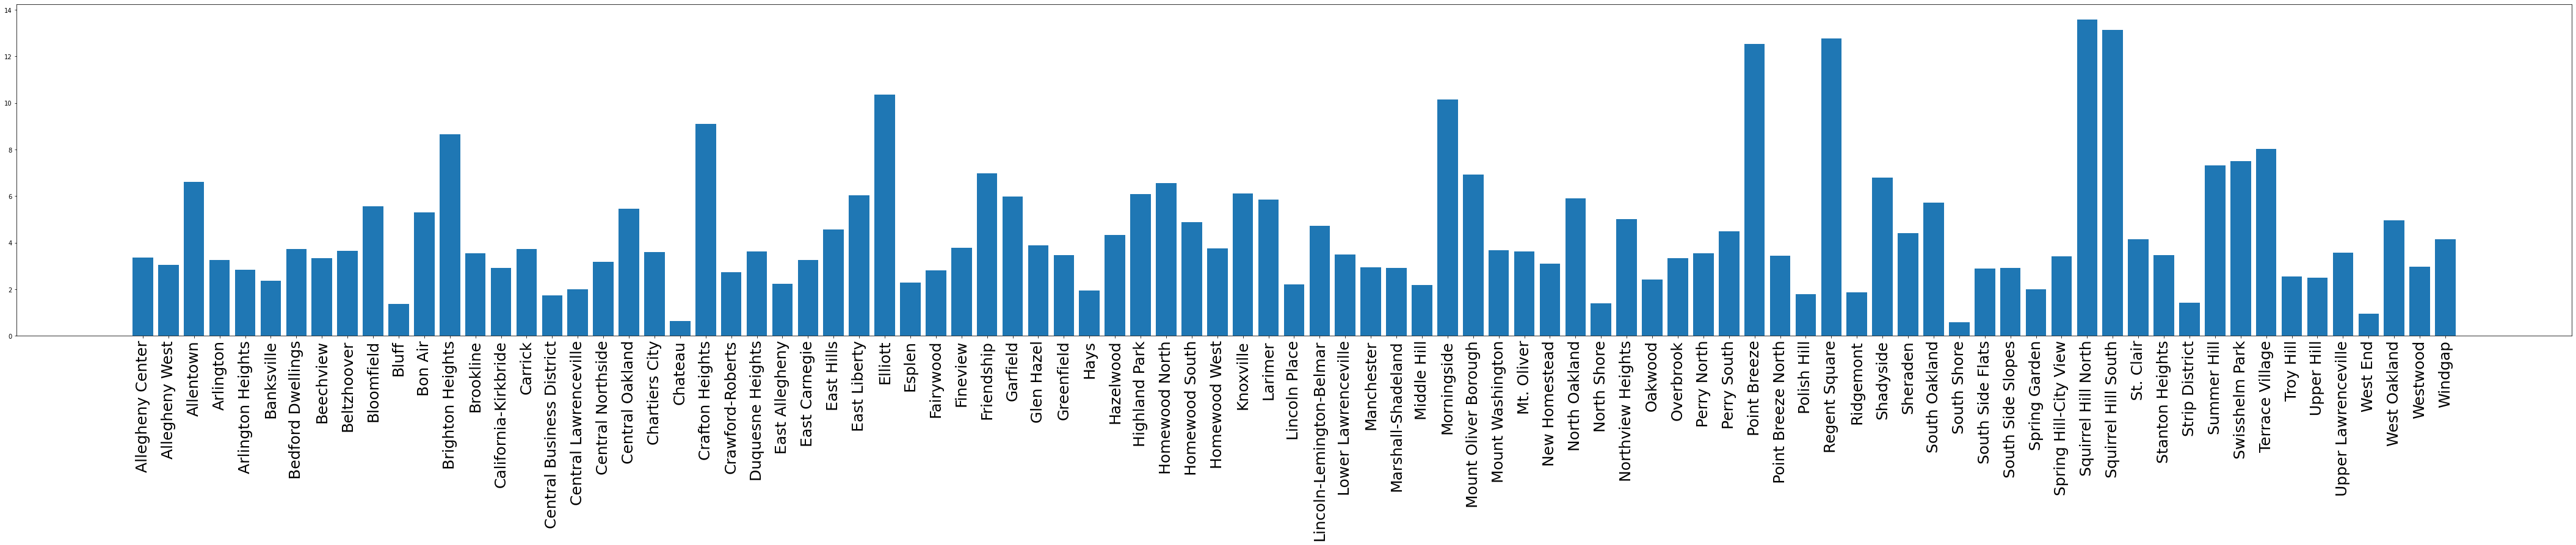

In [51]:
plt.figure(figsize = (75,10))
plt.xticks(rotation = 90)
plt.xticks(fontsize= 25)
plt.bar(finalValues.keys(), finalValues.values())
plt.show()

My results show that 

# Conclusion

## Top 5 Neighborhoods
5 - Regent Square  
4 -  Morning Side  
3 -  Point Breeze  
2 - Squirrel Hill South

## Best Neighborhood

### Squirrel Hill North !!
